# Simulation of the growth and development of an apple tree 1 - Organ Development

In [1]:
from pgljupyter import *
from math import *

# Generating organ shape

## Patch object

A geometrical object can be created to represent the leaf. L-Py offer the possibility to edit Nurbs patch. Notebook version only allow for now to defined them programmatically.


In [2]:
from openalea.plantgl.all import *

leafshape = NurbsPatch([[(-0.0241355, -0.0549754, -0.00804807, 1), (-0.00877065, -0.00933309, 0.00100194, 1), (0.0221632, 0.0405477, -0.00898557, 1), (-0.00223729, -0.00247516, 0.000385988, 1)], 
                        [(0.314084, -0.472921, 0.392759, 1), (0.000957513, 0.000400347, 0.33376, 1), (-0.00092555, 0.00517653, 0.332921, 1), (0.408856, 0.483731, 0.413612, 1)], 
                        [(0.329337, -0.501345, 0.730665, 1), (0.000326354, 0.0164005, 0.665257, 1), (-0.000118909, 0.019707, 0.66817, 1), (0.414001, 0.558038, 0.74373, 1)], 
                        [(0.00223079, 0.0223592, 0.999352, 1), (0.00112035, 0.028812, 1.0005, 1), (-0.000767699, 0.0327184, 0.999658, 1), (-0.0011293, 0.0361733, 1.00279, 1)]])
leafshape.ustride = 6
leafshape.vstride = 6


## Question:

Complete the following model using the leafshape defined previously and the symbol @g to plot such symbol.


 * `@g`: 
    - Draw a geometry at the turtle's current location and orientation. 
    - Parameters : 
       - `geometric_model` : the model to display 
       - `scale_factor` : the scale to apply to the model. optional, should be positive.


In [3]:
%%lpy -w 20

module Leaf(parameters)
module Internode(parameters)

# ParameterSet will be used as parameters. They allow to store any type of parameter and access them by their name
# Example :
# p = ParamerterSet(area=3)
# p.area --> 3
# p.area = 2

Axiom:  Internode(ParameterSet(length = 2, width=0.1)) [&(60) Leaf(ParameterSet(area = 35,ttime = 0)) ]

derivation length: 1
production:
interpretation:

Internode(p) --> _(p.width) F(p.length)

Leaf(p) :
  if p.area > 0:
    length = sqrt(p.area / 1.4)
    produce ,(2) @g(leafshape, length)  


LsystemWidget(derivationLength=2, is_magic=True, scene={'data': b'x\xdaSLrw\xf5\xf7e`Pp\xe0\xe5RPVVdg```be\x08…

# Modelling organ growth

## Loading meteo data

In [4]:
# Loading meteo data
import training.utils.meteo as meteo
from training.utils.meteo import *
init_temperatures()

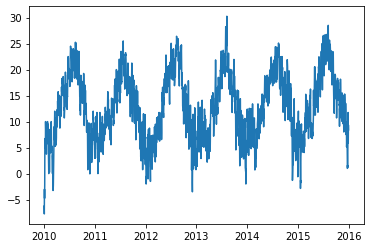

In [5]:
# Example of Use

get_temperature(date(2010,1,1))

from matplotlib.pyplot import *
%matplotlib inline

plot(get_all_dates(), get_all_temperatures())
show()

## Modelling thermal time

Thermal time consists in accumulating each day the temperature above a given base temperature $t_0$. 

<center>
    $tt = \sum_{t}{t-t_0}$ if t>t_0
</center>

## Question :

Complete the function `get_effective_temperature` so that the temperature above `self.base_temperature` is returned in the `ThermalTime`object.

In [6]:
base_temperature = 5

class ThermalTime:
    def __init__(self, base_temperature):
        self.base_temperature = base_temperature
    def get_effective_temperature(self, cdate):
        ctemp = get_temperature(cdate)
        ## TOCOMPLETE
        return max(0, ctemp-self.base_temperature)
    def get_effective_temperatures(self, beg_date, end_date):
        return [max(0,ctemp-self.base_temperature) for ctemp in get_temperatures(beg_date, end_date)]

# a global variable that makes it possible to compute effective temperature
mthermaltime = ThermalTime(base_temperature)

## Organ final size

We distinguish the organ produced at the begining of the growth unit (preformed) from the other ones.

In [7]:
# Parameters
FinalLeafArea1 = 12.
FinalLeafArea2 = 25.

InternodeLength1 = 1
InternodeMaxLength = 2.0

InternodeRadius = 0.3 

In [8]:
def leaf_area(rank):
    if rank < 7:   return FinalLeafArea1
    else:          return FinalLeafArea2

def internode_length(rank, maxlength = InternodeMaxLength):
    if rank < 7:   return maxlength/3
    else:          return maxlength        

## Organ expansion

Growth will be modelled with a logistic function of the shape.

<center>
$ s(t) = \frac{A}{1+exp^{-\frac{t-t_{ip}}{b}}}$
</center>

With $A$ the maximum size, $t_{ip}$ the time at inflexion point and $b$ a slope parameter.

The rate of growth, defined as the derivative of the previous logistic function, will be

<center>
$ \frac{ds}{dt} = \frac{A.exp^{-\frac{t-t_{ip}}{b}} }{ b.(1+exp^{-\frac{t-t_{ip}}{b}})^2}$
</center>

## Question :
Complete the following function using the previous equations

In [9]:
from math import exp

def growth_logistic(ttime, finalsize, tip, b):
    ## TOCOMPLETE
    return finalsize / (1 + exp(-(ttime-tip)/b ))

def growth_rate(ttime, finalsize, tip, b):
    ## TOCOMPLETE
    g = exp(-(ttime-tip)/b )
    return (finalsize * g)  / ( b * pow((1+g),2))



Utility functions to integrate the previous functions over a period.

In [10]:
def growth_logistic_at_date(begdate, cdate, finalsize, tip, b):
    ttime = sum(mthermaltime.get_effective_temperatures(begdate, cdate))
    return growth_logistic(ttime, finalsize, tip, b)

def growth_rate_at_date(begdate, cdate, finalsize, tip, b):
    ttime = sum(mthermaltime.get_effective_temperatures(begdate, cdate))
    return growth_rate(ttime, finalsize, tip, b)

Plot of the growth logistic over a period.

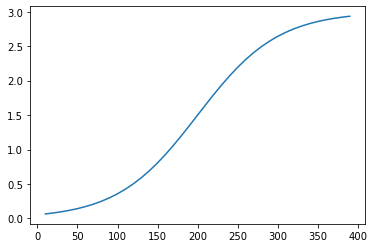

In [11]:
from matplotlib.pyplot import *
%matplotlib inline

r = range(10, 400, 10)
plot(r, [growth_logistic(ttime, 3, 200, 50.) for ttime in r])
show()

We can parameterize the previous function with the following value for the leaf and internode.

In [12]:
# Parameters
tip_leaf = 100.
tip_internode = 100.

b_leaf = 30.
b_internode = 30.

## Question :
With the following code check whether if you integrate the `growth_rate` over the period you reach similar result than with `growth_logistic`

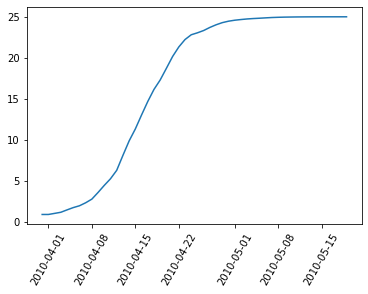

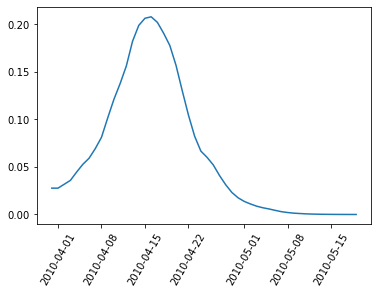

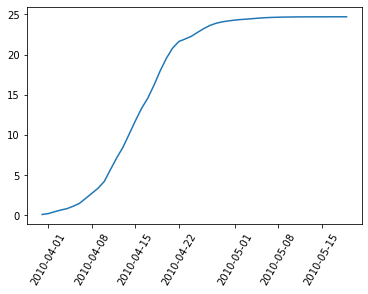

In [13]:
from matplotlib.pyplot import *
%matplotlib inline

# Example of Use
begdate = date(2010,4,1)
growthperiod = [begdate+timedelta(days=i-1) for i in range(50)]

plot(growthperiod, list(map(lambda d : growth_logistic_at_date(begdate, d, FinalLeafArea2, tip_leaf, b_leaf), growthperiod)))
xticks(rotation= 60)
show()

rate = list(map(lambda d : growth_rate_at_date(begdate, d, FinalLeafArea2, tip_leaf, b_leaf), growthperiod))
plot(growthperiod, rate)
xticks(rotation= 60)
show()

from numpy import dot, cumsum
integration = [a*b for a,b in zip(mthermaltime.get_effective_temperatures(begdate, begdate+timedelta(days=50)),rate)]
plot(growthperiod, cumsum(integration))
xticks(rotation= 60)
show()

## Modeling organ development

Using L-Py and the previous equations, we will model the developement of leaves and internodes.


In [14]:
cdate = None

def get_cdate():
  return cdate

def init_cdate():
  global cdate  
  cdate = meteo.get_first_day_for_temperature()+timedelta(days=120)
  return cdate

def increment_cdate():
  global cdate
  cdate += timedelta(days=1)

init_cdate()

def Start():
  init_cdate()

def StartEach():
  increment_cdate()

## Question
Complete the following lpy model.

If you prefer to edit in lpystudio, open and complete in L-Py [organdevelop.lpy](./organdevelop.lpy)


In [16]:
%%lpy -w 5 -a True

module Leaf(parameters)
module Internode(parameters)
# ParameterSet will be used as parameters.

Axiom: 
    nproduce Internode(ParameterSet(length=0.01, finallength = internode_length(rank = 1), width=0.01, ttime = 0)) 
    produce [&(60) Leaf(ParameterSet(area=0, finalarea = leaf_area(rank = 1), ttime = 0)) ]

derivation length: 100
production:

Internode(p) :
  p = p.copy()
  cttime = mthermaltime.get_effective_temperature(cdate)
  
  p.length += growth_rate(p.ttime, p.finallength, tip_internode, b_internode)*cttime
  p.width += growth_rate(p.ttime, 0.1, tip_internode, b_internode)*cttime
  p.ttime += cttime
  
  produce Internode(p)

Leaf(p):
  p = p.copy()
  cttime = mthermaltime.get_effective_temperature(cdate)
  
  p.area += growth_rate(p.ttime, p.finalarea, tip_leaf, b_leaf)*cttime
  p.ttime += cttime
  
  produce Leaf(p)

interpretation:

Internode(p) --> _(p.width) F(p.length)

Leaf(p) :
  if p.area > 0:
    length = sqrt(p.area / 1.4)
    produce ,(2) @g(leafshape, length)

endlsystem

LsystemWidget(animate=True, derivationLength=101, is_magic=True, scene={'data': b'x\xdaSLrw\xf5\xf7e`Pp\xe0\xe…

# Modeling growth units development

## Growth unit length

In [17]:
from training.utils.namedenum import enum
enum('ShortGU', 'LongGU', 'Inflo', 'TrunkGU', 'Blind')

gulengthlaw = { 
    ShortGU : (5, 0.5),
    LongGU : (18, 7),
    Inflo : (3, 0.2),
    TrunkGU : (50, 6.5)
              }

from random import gauss

def growth_unit_length(gutype, parentlength = None):
    mean, sd = gulengthlaw[gutype]
    res = int(gauss(mean,sd))
    if parentlength != None and gutype == LongGU:
        parentlength *= 0.9
        while parentlength < res:
            res = int(gauss(mean,sd))
    return res


## Growth Unit production

The rate of production of metamers by the apex of the GU is given with the following equation

$R_i(d) = r_i * T_{eff}(d)$ if $N_i(d)<N_{f,i}$ and $d < D_e$

       = 0 else

with $r_i$ the rate of metamer production in thermal time, $T_{eff}(d)$ the accumulated thermal time at date $d$, $N_{f,i}$ the final number of metamer and $D_e$ the date of plant growth arrest.

This equation will be modeled by the `MetamerProduction` structure that will accumulate thermal time and determine the number of metamer to produce accordingly.

In [18]:
metamerprodrate = 0.05
date_end_production = 252

In [19]:
class MetamerProduction:
    def __init__(self, rate, nbfinalmetamer, maxdate = date_end_production):
        self.rate = rate
        self.nbfinalmetamer = nbfinalmetamer
        self.nbmetamer = 0
        self.maxdate = maxdate
    
    def copy(self):
        from copy import deepcopy
        return deepcopy(self)
    
    def accumulate(self, cdate):
        # Accumulate the degree days corresponding to the day. 
        # According to the rate of production, some metamers are produced.
        # Return the number of metamer to produce
        ttime = mthermaltime.get_effective_temperature(cdate)
        if self.nbmetamer < self.nbfinalmetamer and (cdate -date(cdate.year,1,1)).days < self.maxdate :
            production = self.rate*ttime
            prevnbmetamer = int(self.nbmetamer)
            self.nbmetamer += production
            if int(self.nbmetamer) >  prevnbmetamer:
                return int(self.nbmetamer) - prevnbmetamer
            return 0
        return 0
    
    def accumulate_range(self, prevdate, cdate):
        # Accumulate degree days over a range of date
        sumi = 0
        for i in range(1,(cdate-prevdate).days+1):
            sumi += self.accumulate(prevdate+timedelta(days=i))
        return sumi

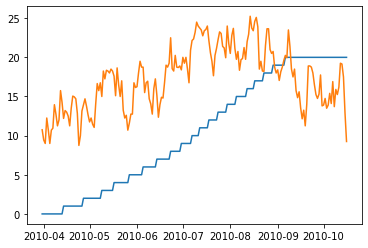

In [68]:
from matplotlib.pyplot import *
%matplotlib inline
from numpy import cumsum

m = MetamerProduction(0.01, 100)
dates = [begdate+timedelta(days=i-1) for i in range(200)]
production = cumsum([m.accumulate(d) for d in dates])

plot(dates, production)
plot(dates, [get_temperature(d) for d in dates])
show()

## Modeling GU development


## Question

Complete the rule for meristem to account for the GU development.

If you prefer to edit in lpystudio, open and complete in L-Py the model [axis.lpy](./axis.lpy)

In [70]:
%%lpy -w 5

module Leaf(parameters)
module Internode(parameters)
# ParameterSet will be used as parameters.

module Meristem(parameters)
# MetamerProduction will be used as parameters.

Axiom:
  nbmetamer = growth_unit_length(TrunkGU)
  produce Meristem(MetamerProduction(metamerprodrate, nbmetamer))

derivation length: 100
production:

Meristem(p):
  p = p.copy()
  # Retrieve current nb of metamers produce by the meristem (p.metamer)
  # accumulate the temperature and retrieve the nb of new metamers to produce
  previousnbmetamer = p.nbmetamer
  nbnewmetamer = p.accumulate(cdate)
  for i in range(nbnewmetamer):
    #    produce an Internode whose finallength is given by the internode_length function, length and width and ttime set to 0
    #    produce symbol for phyllotaxy (144 for the apple tree)
    #    produce lateraly (with a branching angle of 60) a leaf whose finalarea is given by function leaf_area, and area and width and ttime set to 0
    nproduce Internode(ParameterSet(length=0.01, finallength = internode_length(rank = previousnbmetamer+i), width=0.01, ttime = 0))
    nproduce /(144) [&(60) Leaf(ParameterSet(area=0, finalarea = leaf_area(rank = previousnbmetamer+i), ttime = 0)) ]
  produce Meristem(p)


Internode(p) :
  cttime = mthermaltime.get_effective_temperature(cdate)
  p.length += growth_rate(p.ttime, p.finallength, tip_internode, b_internode)*cttime
  p.width += growth_rate(p.ttime, InternodeRadius, tip_internode, b_internode)*cttime
  p.ttime += cttime  
  produce Internode(p)

Leaf(p):
  cttime = mthermaltime.get_effective_temperature(cdate) 
  p.area += growth_rate(p.ttime, p.finalarea, tip_leaf, b_leaf)*cttime
  p.ttime += cttime
  produce Leaf(p)

interpretation:

Internode(p) --> _(p.width) F(p.length)

Leaf(p) :
  if p.area > 0:
    length = sqrt(p.area / 1.4)
    produce ,(2) @g(leafshape, length)

LsystemWidget(derivationLength=101, is_magic=True, scene={'data': b'x\xdaSLrw\xf5\xf7e`Pp\xe0\xe5RPVVd\x00\x02…

To continue, you should look at the [notebook on architecture](./"Apple Tree Simulation - Architecture.ipynb").